# Config

In [1]:
import time
import datetime

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
PARTICIPANT_ID = '1'

# Load data

In [3]:
participant_df = pd.read_csv(f'./raw_data/participant.csv')
participant_df.head()

,id,creation_date,participant_group,participant_type,submission_date,answers_d1,answers_d2,demographic_info
0,1,2024-07-03 09:47:27.324685,A,ADMINISTRATIVE,2024-07-03 10:04:27.799306,530cf9cf-599a-4475-bb7c-845f0b1ee745,59bea0a7-e80a-4912-8f74-206ed6e6da88,03b757a4-1d34-4402-a7f6-076c3e3df170
1,10,2024-07-03 09:48:26.727449,B,ADMINISTRATIVE,2024-07-03 10:04:52.056617,8e638297-f55f-44cd-861d-8232d75a1e42,4f47663a-17b7-47d8-ba57-4d201b59c0f3,4c7743a4-24f8-4ade-b013-2d0e8c45ba8f
2,11,2024-07-03 09:48:24.888290,A,ADMINISTRATIVE,2024-07-03 10:03:03.416511,d53c8d4f-d8d3-40f3-a542-9f28368bbe4c,2d8a2714-9646-42d9-a5ec-95145019e3d7,62dc7caa-b574-4c9f-90c2-b4e42c0c3e0f
3,13,2024-07-03 09:48:18.365622,C,ADMINISTRATIVE,2024-07-03 10:05:14.581160,bc2cece9-fdf8-4e94-9b3b-9d85202dcf17,76bc07e9-1c23-4830-ae9f-37d4498f6a66,c84fffc1-00e0-4727-b240-95733855664c
4,14,2024-07-03 09:48:09.720491,B,ADMINISTRATIVE,2024-07-03 10:07:08.696679,aa7baabe-eb18-4267-898c-a04dc84f9303,c7b1fb8b-c014-4bbd-b3da-babbb3960da3,d9a0dba9-0446-444f-82dc-30c6813fd6d1


In [4]:
survey_event_df = pd.read_csv(f'./raw_data/survey_event.csv')
survey_event_df.head()

,id,event,timestamp,participant
0,1,d1 | visible | text,1719827039609,UEFSVEVDSVBBTlRFXzgy
1,2,d1 | invisible | q6,1719827039597,UEFSVEVDSVBBTlRFXzgy
2,3,d1 | invisible | q5,1719827039607,UEFSVEVDSVBBTlRFXzgy
3,4,survey | load,1719827039268,UEFSVEVDSVBBTlRFXzgy
4,5,d1 | invisible | q2,1719827039605,UEFSVEVDSVBBTlRFXzgy


# Flow by participant

In [5]:
CHARTS_TYPE = ['text', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']

In [6]:
def get_events_list(df, participant_id, start_min):
  sub_df = df[survey_event_df['participant'] == participant_id]
  sub_df = sub_df.sort_values('timestamp')
  sub_df['timestamp'] = (sub_df['timestamp'] / 1e3 / 60) - start_min
  sub_df = sub_df.rename(columns={'event': 'name', 'timestamp': 't'})
  sub_df = sub_df[['t', 'name']]
  return sub_df.to_dict(orient='records')

In [7]:
def evaluate_spans(_events_list):
  # labs spans
  survey_load = next(e['t'] for e in _events_list if e['name'] == 'survey | load')
  lab1_submit = next(e['t'] for e in _events_list if e['name'] == 'survey | lab1 submit')
  lab2_submit = next(e['t'] for e in _events_list if e['name'] == 'survey | lab2 submit')
  lab1_span = (survey_load, lab1_submit)
  lab2_span = (lab1_submit, lab2_submit)

  # visibility_stapns
  d1_visibility_spans = {}
  d2_visibility_spans = {}
  for TYPE in CHARTS_TYPE:
    visibles = [e['t'] for e in _events_list if e['name'] == f'd1 | visible | {TYPE}']
    invisibles = [e['t'] for e in _events_list if e['name'] == f'd1 | invisible | {TYPE}' and e['t'] > visibles[0]]
    d1_visibility_spans[TYPE] = [(visibles[i], invisibles[i]) for i in range(min(len(visibles), len(invisibles)))]

    visibles = [e['t'] for e in _events_list if e['name'] == f'd2 | visible | {TYPE}']
    invisibles = [e['t'] for e in _events_list if e['name'] == f'd2 | invisible | {TYPE}' and e['t'] > visibles[0]]
    d2_visibility_spans[TYPE] = [(visibles[i], invisibles[i]) for i in range(min(len(visibles), len(invisibles)))]

  # hover_spans
  d1_hover_spans = {}
  d2_hover_spans = {}
  for TYPE in CHARTS_TYPE:
    hovers = [e['t'] for e in _events_list if e['name'] == f'd1 | hover | {TYPE}']
    leaves = [e['t'] for e in _events_list if e['name'] == f'd1 | leave | {TYPE}' and e['t'] > hovers[0]]
    d1_hover_spans[TYPE] = [(hovers[i], leaves[i]) for i in range(min(len(hovers), len(leaves)))]

    hovers = [e['t'] for e in _events_list if e['name'] == f'd2 | hover | {TYPE}']
    leaves = [e['t'] for e in _events_list if e['name'] == f'd2 | leave | {TYPE}' and e['t'] > hovers[0]]
    d2_hover_spans[TYPE] = [(hovers[i], leaves[i]) for i in range(min(len(hovers), len(leaves)))]

  return lab1_span, lab2_span, d1_visibility_spans, d2_visibility_spans, d1_hover_spans, d2_hover_spans

In [8]:
def evaluate_points(_events_list):
  # question points
  d1_question_points = {}
  d2_question_points = {}

  for TYPE in CHARTS_TYPE:
    points = [(e['t'], int(e['name'].split(' | ')[-1])) for e in _events_list if f'd1 | question | {TYPE} | ' in e['name']]
    d1_question_points[TYPE] = points

  for TYPE in CHARTS_TYPE:
    points = [(e['t'], int(e['name'].split(' | ')[-1])) for e in _events_list if f'd2 | question | {TYPE} | ' in e['name']]
    d2_question_points[TYPE] = points

  # dialog points
  d1_dialog_open_points = [(e['t'], 1) for e in _events_list if f'd1 | dialog | open' == e['name']]
  d2_dialog_open_points = [(e['t'], 1) for e in _events_list if f'd2 | dialog | open' == e['name']]

  d1_dialog_dismiss_points = [(e['t'], 2) for e in _events_list if f'd1 | dialog | dismiss' == e['name']]
  d2_dialog_dismiss_points = [(e['t'], 2) for e in _events_list if f'd2 | dialog | dismiss' == e['name']]

  d1_dialog_accept_points = [(e['t'], 3) for e in _events_list if f'd1 | dialog | accept' == e['name']]
  d2_dialog_accept_points = [(e['t'], 3) for e in _events_list if f'd2 | dialog | accept' == e['name']]

  return d1_question_points, d2_question_points, d1_dialog_open_points, d2_dialog_open_points, d1_dialog_dismiss_points, d2_dialog_dismiss_points, d1_dialog_accept_points, d2_dialog_accept_points

In [9]:
def span_rectangle(span, h, color):
  return Rectangle((span[0], 0), span[1] - span[0], h, facecolor=np.array(color)/255)

19.0
[{'t': 0.006683334708213806, 'name': 'survey | load'}, {'t': 0.008249998092651367, 'name': 'd1 | invisible | q6'}, {'t': 0.008266668766736984, 'name': 'd1 | invisible | rate'}, {'t': 0.008266668766736984, 'name': 'd1 | invisible | q4'}, {'t': 0.008266668766736984, 'name': 'd1 | invisible | q1'}, {'t': 0.008266668766736984, 'name': 'd1 | invisible | q3'}, {'t': 0.008283331990242004, 'name': 'd1 | visible | text'}, {'t': 0.008283331990242004, 'name': 'd1 | invisible | q5'}, {'t': 0.008283331990242004, 'name': 'd1 | invisible | q2'}, {'t': 0.012050002813339233, 'name': 'd1 | hover | text'}, {'t': 0.07460000365972519, 'name': 'd1 | leave | text'}, {'t': 0.08954999968409538, 'name': 'd1 | visible | q1'}, {'t': 0.09456666931509972, 'name': 'd1 | visible | q2'}, {'t': 0.1007000021636486, 'name': 'd1 | visible | q3'}, {'t': 0.10093333572149277, 'name': 'd1 | invisible | text'}, {'t': 0.10204999893903732, 'name': 'd1 | visible | q4'}, {'t': 0.11121666803956032, 'name': 'd1 | invisible | q4

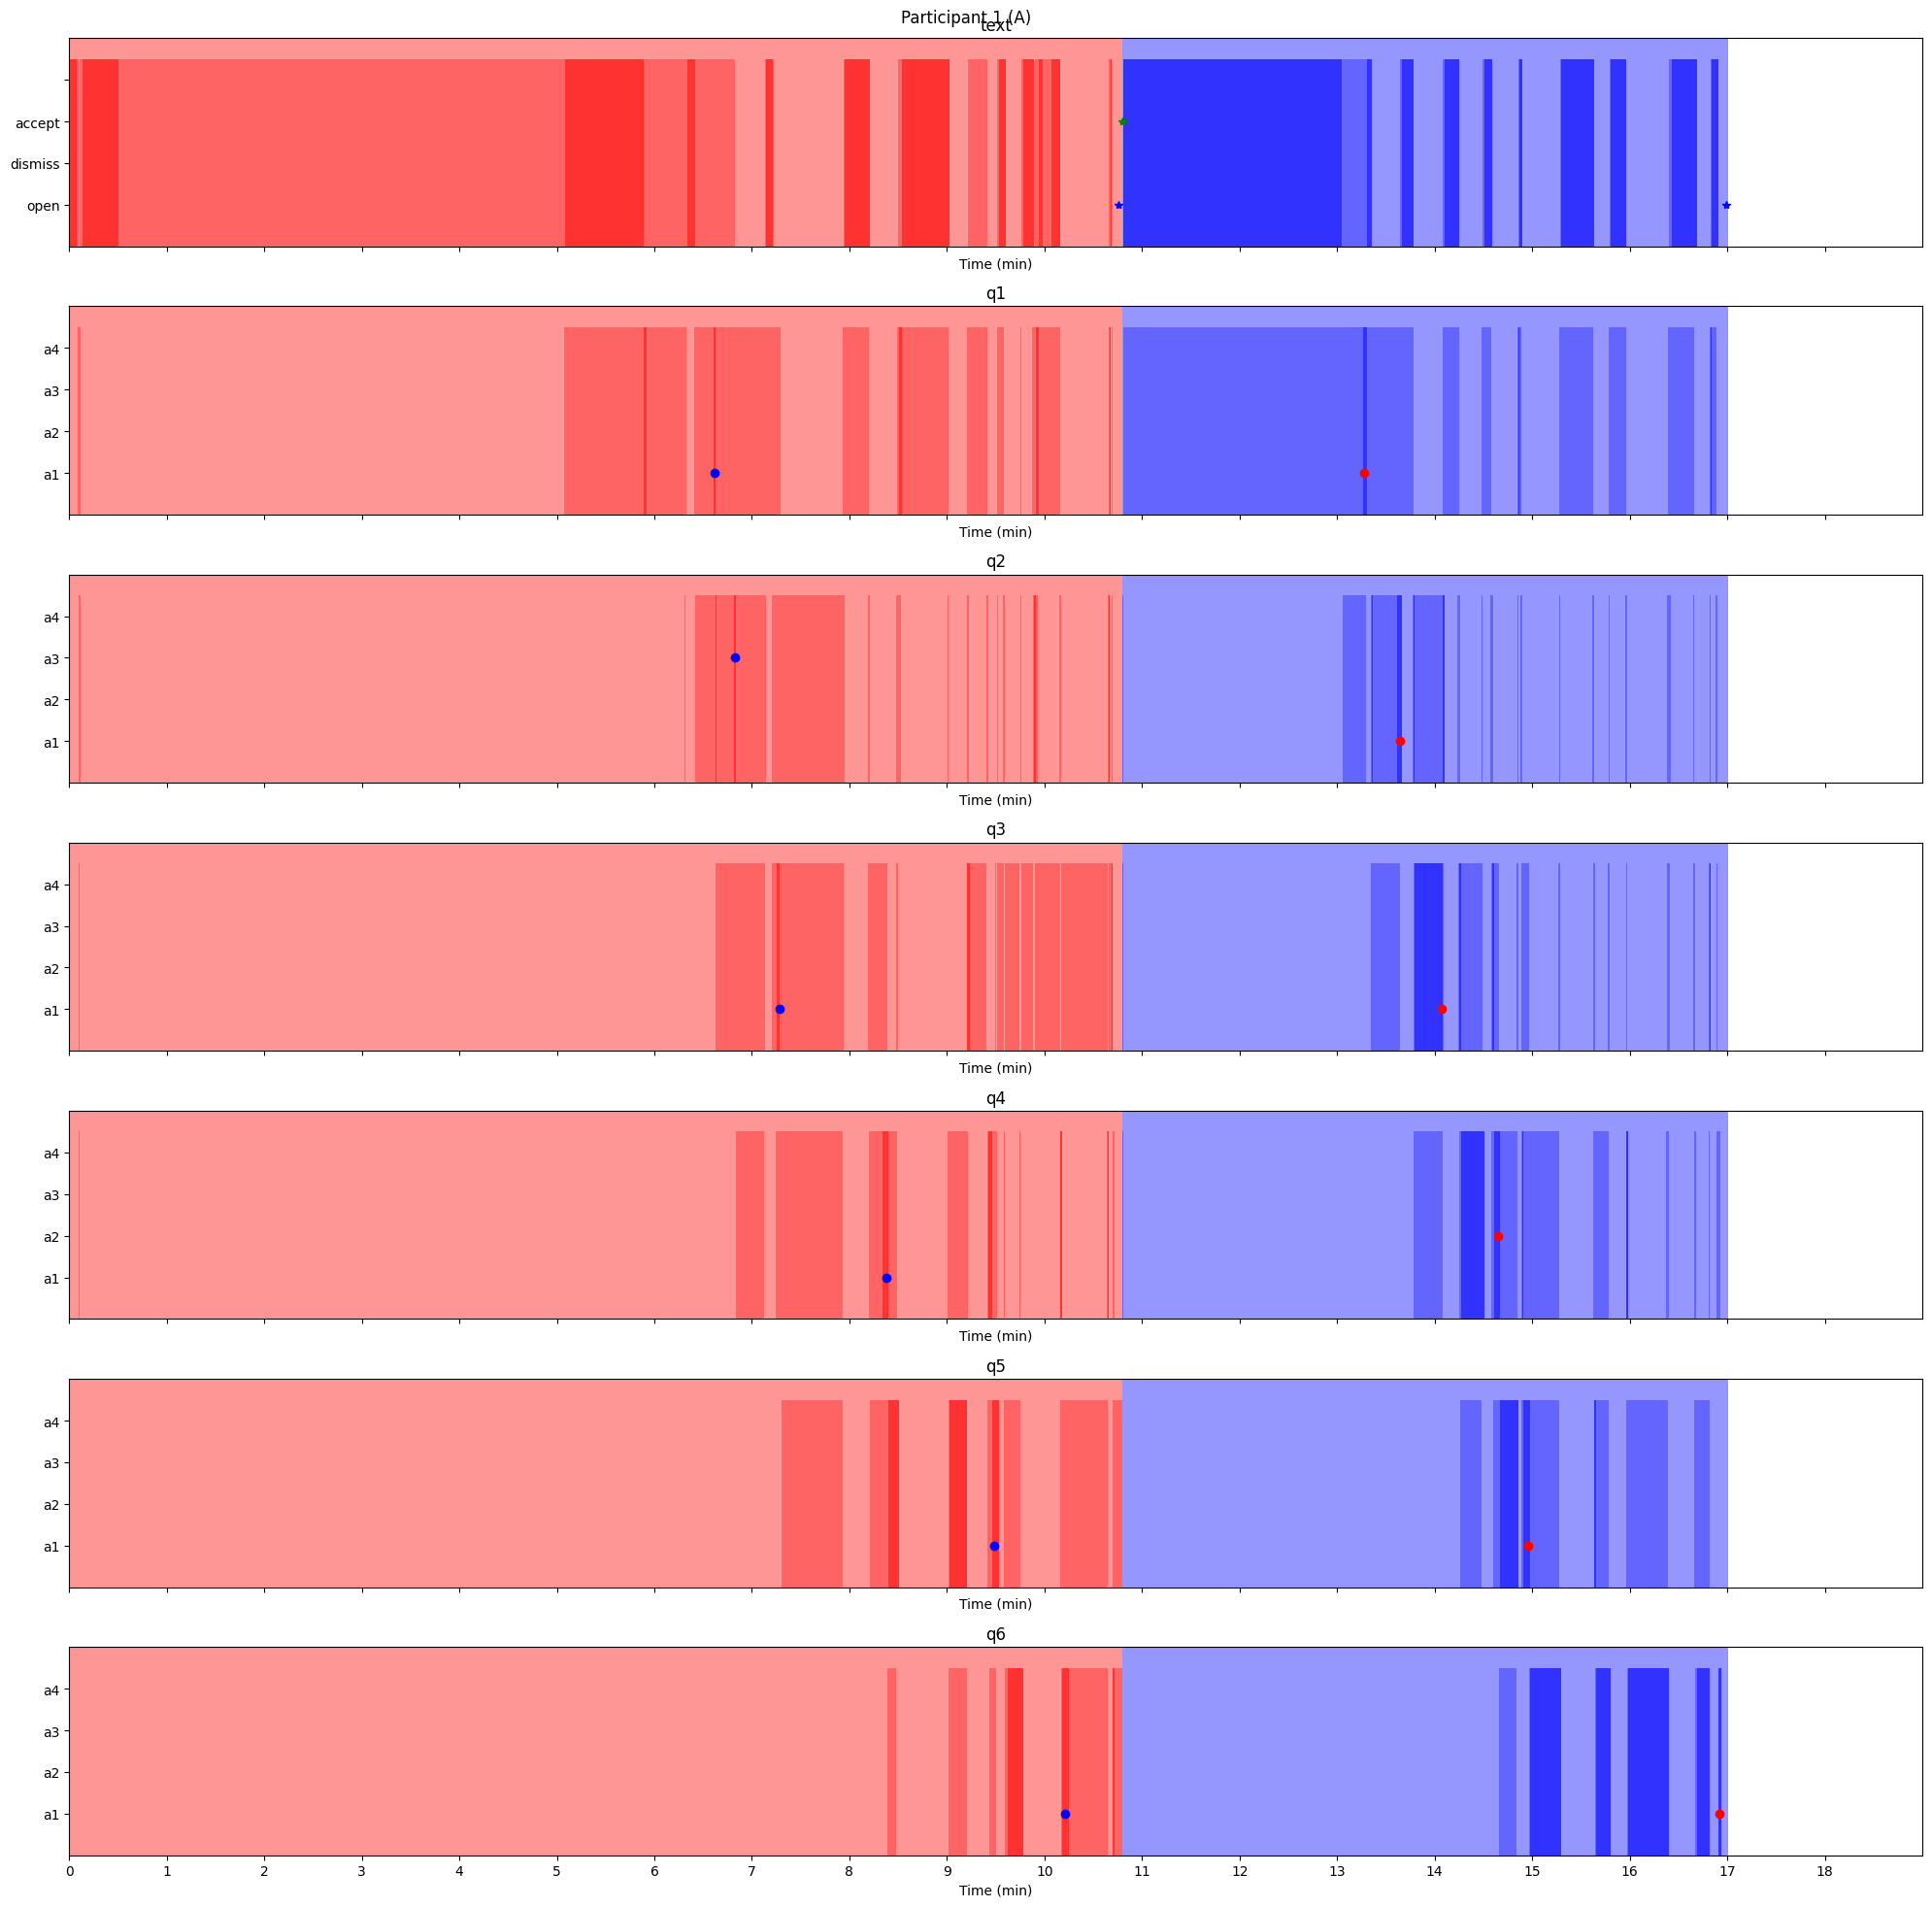

In [10]:
participant = participant_df[participant_df['id'] == PARTICIPANT_ID].iloc[0]
participant_id = participant['id']
participant_group = participant['participant_group']

start_min = (time.mktime(datetime.datetime.strptime(participant['creation_date'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) + (2 * 60 * 60)) / 60
end_min = (time.mktime(datetime.datetime.strptime(participant['submission_date'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) + (2 * 60 * 60)) / 60
duration = ((end_min - start_min) + 2)
print(duration)

events_list = get_events_list(survey_event_df, participant_id, start_min)
print(events_list)

lab1_span, lab2_span, d1_visibility_spans, d2_visibility_spans, d1_hover_spans, d2_hover_spans = evaluate_spans(events_list)
d1_question_points, d2_question_points, d1_dialog_open_points, d2_dialog_open_points, d1_dialog_dismiss_points, d2_dialog_dismiss_points, d1_dialog_accept_points, d2_dialog_accept_points = evaluate_points(events_list)
print(d2_question_points)

fig, axs = plt.subplots(7, 1, tight_layout=True, figsize=(20, 20), sharex=True)
fig.suptitle(f'Participant {participant_id} ({participant_group})')

print('a')
# Setup axs
for i, ax in enumerate(axs):
    ax.set_ylim(0, 5)
    ax.set_xlim(0, duration)
    ax.set_title(CHARTS_TYPE[i])
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(['a1', 'a2', 'a3', 'a4'])
    ax.set_xlabel('Time (min)')
    ax.set_xticks(np.arange(0, duration, 1))
    axs[0].set_yticklabels(['open', 'dismiss', 'accept', ''])
print('a')
# Show lab spans
for ax in axs:
    if participant_group == 'A' or participant_group == 'B':
        ax.add_patch(span_rectangle(lab1_span, 5, (255, 150, 150)))
        ax.add_patch(span_rectangle(lab2_span, 5, (150, 150, 255)))
    else:
        ax.add_patch(span_rectangle(lab1_span, 5, (150, 150, 255)))
        ax.add_patch(span_rectangle(lab2_span, 5, (255, 150, 150)))
print('a')
# Show visibility spans
for i, TYPE in enumerate(CHARTS_TYPE):
    for span in d1_visibility_spans[TYPE]:
        axs[i].add_patch(span_rectangle(span, 4.5, (255, 100, 100)))

    for span in d2_visibility_spans[TYPE]:
        axs[i].add_patch(span_rectangle(span, 4.5, (100, 100, 255)))
print('a')
# Show hover spans
for i, TYPE in enumerate(CHARTS_TYPE):
    for span in d1_hover_spans[TYPE]:
        axs[i].add_patch(span_rectangle(span, 4.5, (255, 50, 50)))

    for span in d2_hover_spans[TYPE]:
        axs[i].add_patch(span_rectangle(span, 4.5, (50, 50, 255)))
print('a')
# Show question points
for i, TYPE in enumerate(CHARTS_TYPE):
    for p in d1_question_points[TYPE]:
        axs[i].plot(p[0], p[1], 'bo', label='d1')

    for p in d2_question_points[TYPE]:
        axs[i].plot(p[0], p[1], 'ro', label='d2')

# Show dialog poins
for p in d1_dialog_open_points:
    axs[0].plot(p[0], p[1], 'b*', label='open d1')

for p in d2_dialog_open_points:
    axs[0].plot(p[0], p[1], 'b*', label='open d2')

for p in d1_dialog_dismiss_points:
    axs[0].plot(p[0], p[1], 'r*', label='dismiss d1')

for p in d2_dialog_dismiss_points:
    axs[0].plot(p[0], p[1], 'r*', label='dismiss d2')

for p in d1_dialog_accept_points:
    axs[0].plot(p[0], p[1], 'g*', label='accept d1')

for p in d2_dialog_accept_points:
    axs[0].plot(p[0], p[1], 'g*', label='accept d2')

plt.show()